## Pasos del proyecto
1. Consigue los datos
1. Define tu problema de Machine Learning: clasifiación/regresión, supervisado/ no supervisado, series temporales, imágenes, texto...
1. Exploratorio: obtén todos los estadísticos y gráficos que necesites para entender bien tu dataset.
1. Limpia los datos: duplicados, missings, outliers, columnas inútiles...
1. Feature engineering: transformación y creación de nuevas variables.
1. Prueba varios modelos
1. Analiza los resultados mediante una métrica adecuada a tu problemática.
1. Interpreta los resultados y comprende los outputs del modelo.
1. Siguientes pasos. ¿Se puede enriquecer el modelo con otras pruebas o con otros datos?
1. Bonus track (opcional): monta un dashboard/informe donde se vea cómo aprende tu modelo, qué hiperparámetros usa y resultados obtenidos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

%run "funciones.ipynb"

In [2]:
#Carga de datos
df=pd.read_csv('21239_breast_cancer_survival.csv')
df.head(10)

,Patient_ID,Age,Marital_Status,Year of Operation,Positive_Axillary_Nodes,Tumor_Size,Radiation_Therapy,Chemotherapy,Hormone_Therapy,Survival_Status
0,eca1411e,36,Married,1959,3,1.7,Yes,Yes,No,2
1,63e3301c,39,Married,1966,0,1.6,Yes,No,No,2
2,01647916,71,Single,1964,3,3.1,No,No,No,2
3,07e33840,50,Married,1960,0,3.0,Yes,No,Yes,1
4,ed75da3f,44,Married,1965,4,2.6,Yes,No,No,1
5,53d35fd5,51,Married,1961,3,0.6,Yes,No,No,1
6,e004b1d7,65,Married,1958,0,0.8,No,No,No,1
7,c18ba47d,83,Single,1967,0,1.7,Yes,Yes,No,2
8,e8b048ea,60,Married,1960,3,3.8,Yes,Yes,No,2
9,3aad5adf,38,Married,1959,1,1.7,Yes,Yes,No,1


Limpieza y modificación del dataset

In [30]:
#Encontrar duplicadas
df.duplicated().sum()

1

In [32]:
#Identificar duplicada
fila_duplicada = df[df.duplicated()]
print(fila_duplicada)

      Age  Marital_Status  Year of Operation  Positive_Axillary_Nodes  \
1008   41               0               1967                        7   

      Tumor_Size  Radiation_Therapy  Chemotherapy  Hormone_Therapy  \
1008         4.5                  1             0                0   

      Survival_Status  
1008                1  


In [34]:
#Eliminar duplicada
df=df.drop(1008)

In [35]:
df.duplicated().sum()

0

In [4]:
#Sustituimos por valores binarios (0,1)
df['Survival_Status'] = df['Survival_Status'].replace({2: 0})
df['Radiation_Therapy'] = df['Radiation_Therapy'].replace({'No':0,'Yes':1})
df['Chemotherapy'] = df['Chemotherapy'].replace({'No':0,'Yes':1})
df['Hormone_Therapy'] = df['Hormone_Therapy'].replace({'No':0,'Yes':1})
df['Marital_Status'] = df['Marital_Status'].replace({'Single':0,'Married':1})

#Eliminamos 'Patient_ID'
df = df.drop('Patient_ID',axis=1)
df.head()


,Age,Marital_Status,Year of Operation,Positive_Axillary_Nodes,Tumor_Size,Radiation_Therapy,Chemotherapy,Hormone_Therapy,Survival_Status
0,36,1,1959,3,1.7,1,1,0,0
1,39,1,1966,0,1.6,1,0,0,0
2,71,0,1964,3,3.1,0,0,0,0
3,50,1,1960,0,3.0,1,0,1,1
4,44,1,1965,4,2.6,1,0,0,1


EDA

In [ ]:
df.info()


In [ ]:
df.describe()

In [ ]:
#Grafica frecuencias clases survival
df['Survival_Status'].plot(kind='hist')
plt.title('Frecuencia clases survival')

In [ ]:
sns.pairplot(df)

In [ ]:
df.corr()

In [ ]:
#heatmap correlaciones
sns.heatmap(df.corr(), annot=True)

Train & Test

In [5]:
X = df.drop('Survival_Status',axis=1)
y = df['Survival_Status']

x_train, x_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.25,
                                                   random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## MODELOS

LogisticRegression

In [7]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [8]:
predicciones_log_reg = log_reg.predict(x_test_scaled)
print(classification_report(y_test, predicciones_log_reg))

              precision    recall  f1-score   support

           0       0.48      0.65      0.55       242
           1       0.50      0.33      0.40       258

    accuracy                           0.48       500
   macro avg       0.49      0.49      0.47       500
weighted avg       0.49      0.48      0.47       500



In [9]:
log_reg.score(x_test_scaled, y_test)

0.484

In [ ]:
c_matrix_log_reg = confusion_matrix(y_test, predicciones_log_reg)
sns.heatmap(c_matrix_log_reg, annot=True)
print(c_matrix_log_reg)

In [ ]:
matriz_porcentajes(c_matrix_log_reg)

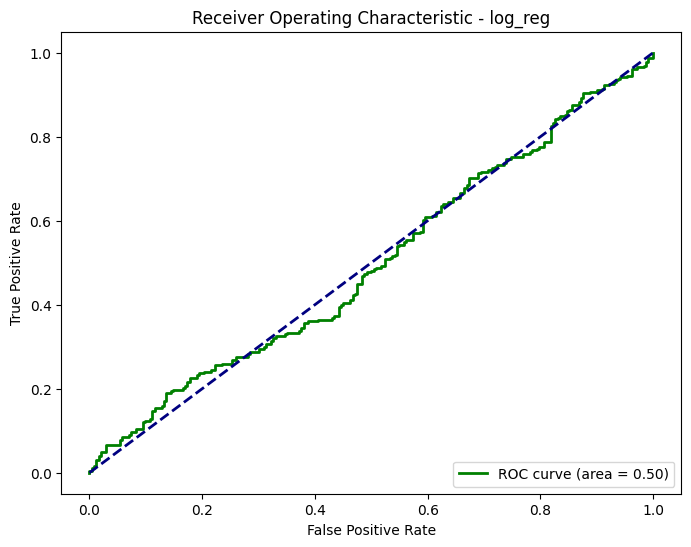

In [10]:
curva_ROC('log_reg',log_reg,x_test_scaled,y_test)

Regresión logística con Grid y Validación cruzada

In [11]:
param_grid = {'max_iter':[1000,2000,3000]}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled, y_train)
mejores_parametros_log_reg = grid_search.best_params_
mejor_modelo_log_reg = grid_search.best_estimator_
rendimiento_log_reg = cross_val_score(mejor_modelo_log_reg, x_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
rendimiento_medio_log_reg = rendimiento_log_reg.mean()
print('mejores parametros:',mejores_parametros_log_reg)
print('rendimiento_ medio:',rendimiento_medio_log_reg)

mejores parametros: {'max_iter': 1000}
rendimiento_ medio: -0.4806666666666667


Nos ha devuelto el mismo modelo de 1000 iteraciones por lo que tendrá identicos resultados

DecisionTreeClassifier

In [12]:
tree_clas = DecisionTreeClassifier(max_depth=3,random_state=42)
tree_clas.fit(x_train_scaled,y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [13]:
predicciones_tree = tree_clas.predict(x_test_scaled)
print(classification_report(y_test, predicciones_tree))

              precision    recall  f1-score   support

           0       0.49      0.94      0.65       242
           1       0.64      0.10      0.17       258

    accuracy                           0.51       500
   macro avg       0.57      0.52      0.41       500
weighted avg       0.57      0.51      0.40       500



In [14]:
tree_clas.score(x_test_scaled,y_test)

0.506

In [15]:
tree_clas.feature_importances_

array([0.41154958, 0.        , 0.        , 0.16814004, 0.11490111,
       0.        , 0.0985463 , 0.20686297])

In [ ]:
plt.figure(figsize=(10,10))
sklearn.tree.plot_tree(tree_clas,filled = True)

In [ ]:
c_matrix_tree = confusion_matrix(y_test, predicciones_tree)
sns.heatmap(c_matrix_tree, annot=True)
print(c_matrix_tree)

In [ ]:
matriz_porcentajes(c_matrix_tree)

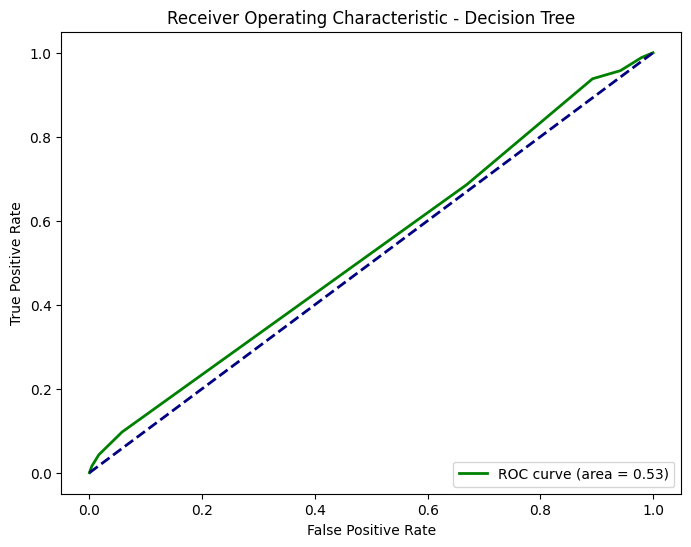

In [16]:
curva_ROC('Decision Tree',tree_clas,x_test_scaled,y_test)

RandomForestClassifier

In [17]:
tree_r_clas = RandomForestClassifier(max_depth=3,random_state=42)
tree_r_clas.fit(x_train_scaled,y_train)

RandomForestClassifier(max_depth=3, random_state=42)

In [18]:
predicciones_tree_r = tree_r_clas.predict(x_test_scaled)
print(classification_report(y_test, predicciones_tree_r))

              precision    recall  f1-score   support

           0       0.51      0.76      0.61       242
           1       0.59      0.32      0.42       258

    accuracy                           0.53       500
   macro avg       0.55      0.54      0.51       500
weighted avg       0.55      0.53      0.51       500



In [19]:
tree_r_clas.score(x_test_scaled,y_test)

0.534

In [20]:
tree_r_clas.feature_importances_

array([0.30420255, 0.0568393 , 0.15431299, 0.16091123, 0.18153596,
       0.0330195 , 0.02259264, 0.08658584])

In [ ]:
c_matrix_tree_r = confusion_matrix(y_test, predicciones_tree_r)
sns.heatmap(c_matrix_tree_r, annot=True)
print(c_matrix_tree_r)

In [ ]:
matriz_porcentajes(c_matrix_tree_r)

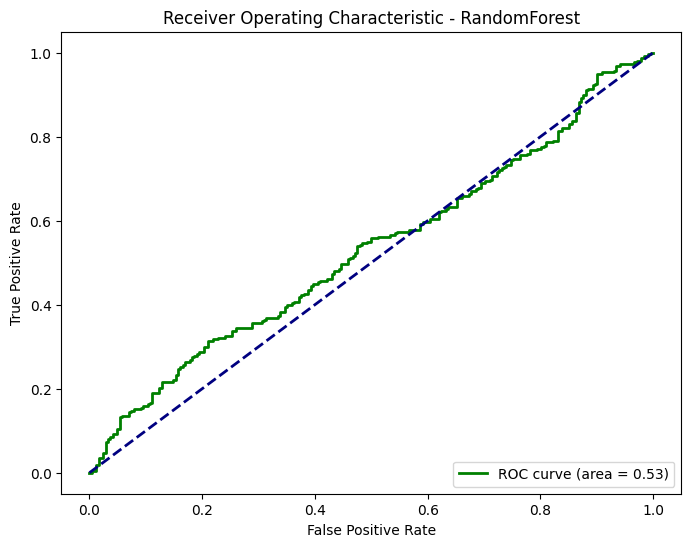

In [22]:
curva_ROC('RandomForest',tree_r_clas,x_test_scaled,y_test)

DecisionTreeClasifier GridSearchCV y cross_val

In [23]:
param_grid = {
    'max_depth': [2, 3, 5,],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(tree_clas, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled, y_train)
mejores_parametros_tree = grid_search.best_params_
mejor_modelo_tree = grid_search.best_estimator_
rendimiento_tree = cross_val_score(mejor_modelo_tree, x_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
rendimiento_medio_tree = rendimiento_tree.mean()
print('mejores parametros:',mejores_parametros_tree)
print('rendimiento_ medio:',rendimiento_medio_tree)

mejores parametros: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
rendimiento_ medio: -0.48533333333333334


In [24]:
predicciones_mejor_modelo_tree = mejor_modelo_tree.predict(x_test_scaled)
print(classification_report(y_test, predicciones_mejor_modelo_tree))

              precision    recall  f1-score   support

           0       0.49      0.95      0.65       242
           1       0.62      0.07      0.13       258

    accuracy                           0.50       500
   macro avg       0.56      0.51      0.39       500
weighted avg       0.56      0.50      0.38       500



In [25]:
mejor_modelo_tree.score(x_test_scaled,y_test)

0.498

In [ ]:
mejor_modelo_tree.feature_importances_

In [ ]:
plt.figure(figsize=(10,10))
sklearn.tree.plot_tree(mejor_modelo_tree,filled = True)

In [ ]:
c_matrix_mejor_modelo_tree = confusion_matrix(y_test, predicciones_mejor_modelo_tree)
sns.heatmap(c_matrix_mejor_modelo_tree, annot=True)
print(c_matrix_mejor_modelo_tree)

In [ ]:
matriz_porcentajes(c_matrix_mejor_modelo_tree)

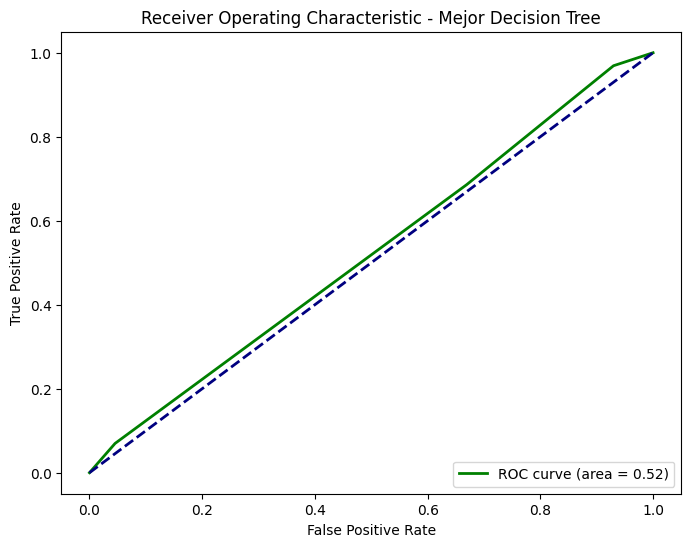

In [26]:
curva_ROC('Mejor Decision Tree',mejor_modelo_tree,x_test_scaled,y_test)

Radomforest GridSearchCV y cross_val

In [27]:
param_grid = {
    'max_depth': [5, 7, 10],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(tree_r_clas, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled, y_train)
mejores_parametros_ran = grid_search.best_params_
mejor_modelo_ran = grid_search.best_estimator_
rendimiento_ran = cross_val_score(mejor_modelo_ran, x_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
rendimiento_medio_ran = rendimiento_ran.mean()
print('mejores parametros:',mejores_parametros_ran)
print('rendimiento_ medio:',rendimiento_medio_ran)

mejores parametros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
rendimiento_ medio: -0.47133333333333327


In [ ]:
predicciones_mejor_modelo_ran = mejor_modelo_ran.predict(x_test_scaled)
print(classification_report(y_test, predicciones_mejor_modelo_ran))

In [ ]:
mejor_modelo_ran.score(x_test_scaled,y_test)

In [ ]:
mejor_modelo_ran.feature_importances_

In [ ]:
c_matrix_mejor_modelo_ran = confusion_matrix(y_test, predicciones_mejor_modelo_ran)
sns.heatmap(c_matrix_mejor_modelo_ran, annot=True)
print(c_matrix_mejor_modelo_ran)

In [ ]:
matriz_porcentajes(c_matrix_mejor_modelo_ran)

In [ ]:
curva_ROC('Mejor Randomforest',mejor_modelo_ran,x_test_scaled,y_test)


Ensembled RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

alg_names = []
cv_score_means = []
rnd_clf = RandomForestClassifier(n_estimators=100,
                                 max_features=3,
                                 random_state=42)

cv_scores = cross_val_score(rnd_clf, x_train_scaled, y_train, cv=5)
print("Resultados de Validación Cruzada:", cv_scores)
print("Precisión Media: {:.2f}".format(cv_scores.mean()))
cv_score_means.append(cv_scores.mean())
alg_names.append('rnd_clf')

In [ ]:
rnd_clf.fit(x_train_scaled,y_train)

In [ ]:
predicciones_rnd_clf = rnd_clf.predict(x_test_scaled)
print(classification_report(y_test, predicciones_rnd_clf))

In [ ]:
rnd_clf.score(x_test_scaled,y_test)

In [ ]:
c_matrix_rnd_clf = confusion_matrix(y_test, predicciones_rnd_clf)
sns.heatmap(c_matrix_rnd_clf, annot=True)
print(c_matrix_rnd_clf)

In [ ]:
matriz_porcentajes(c_matrix_rnd_clf)

In [ ]:
curva_ROC('Mejor Randomforest',rnd_clf,x_test_scaled,y_test)

Ensembled RadomForestClasifier GridSearchCV y cross_val

In [ ]:
from sklearn.ensemble import RandomForestClassifier

alg_names = []
cv_score_means = []
rnd_clf = RandomForestClassifier(n_estimators=100,
                                 max_features=3,
                                 random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [2, 3, 4]
}

grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled, y_train)
mejores_parametros_ens_ran = grid_search.best_params_
mejor_modelo_ens_ran = grid_search.best_estimator_

cv_scores = cross_val_score(mejor_modelo_ens_ran, x_train_scaled, y_train, cv=5)
print("Resultados de Validación Cruzada:", cv_scores)
print("Precisión Media: {:.2f}".format(cv_scores.mean()))

In [ ]:
predicciones_ens_ran = mejor_modelo_ens_ran.predict(x_test_scaled)
print(classification_report(y_test, predicciones_ens_ran))

In [ ]:
mejor_modelo_ens_ran.score(x_test_scaled,y_test)

In [ ]:
c_matrix_ens_ran = confusion_matrix(y_test, predicciones_ens_ran)
sns.heatmap(c_matrix_ens_ran, annot=True)
print(c_matrix_ens_ran)

In [ ]:
matriz_porcentajes(c_matrix_ens_ran)

In [ ]:
curva_ROC('Mejor Ensembled Randomforest',mejor_modelo_ens_ran,x_test_scaled,y_test)

## Conclusiones